# Simple demo on synthetic data

The model is described here: https://www.overleaf.com/project/649e4d41313d17d01bde7cfb


## Notes


In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax.nn import softplus
from fos import seminmf_full as seminmf
from scipy.ndimage import gaussian_filter
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

## Make synthetic 2D dataset for testing

In [52]:
key = jr.PRNGKey(4)
num_mice = 200
height, width = 100, 100
num_factors = 3
emission_noise_scale = 1.0
loading_scale = 100000 
mean_func = softplus

# Sample parameters and data
k1, k2, k3, k4, k5, k6, k7, k8 = jr.split(key, 8)

# Row and column effects
true_count_row_effects = jnp.zeros(num_mice)
true_count_row_effects = tfd.Normal(10, 3).sample(seed=jr.PRNGKey(0), sample_shape=(num_mice,))
true_count_col_effects = jnp.zeros(height* width)
true_intensity_row_effects = jnp.zeros(num_mice)
true_intensity_col_effects = jnp.zeros(height* width)

# Sparse localized factors
xx, yy = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
true_factors = jnp.zeros((num_factors, height, width))
true_factors = true_factors.at[0].set(jnp.where((xx >= 8) & (xx < 20) & (yy >= 20) & (yy < 32), 1.0, 0.0))
true_factors = true_factors.at[1].set(jnp.where((xx >= 60) & (xx < 76) & (yy >= 28) & (yy < 48), 1.0, 0.0))
true_factors = true_factors.at[2].set(jnp.where(((xx - 40)**2 + (yy - 80)**2) <= 16**2, 1.0, 0.0))

# Random smooth factors
# true_factors = tfd.Normal(0.0, 10.0).sample(seed=jr.PRNGKey(123), sample_shape=(num_factors, height, width))
# for k in range(num_factors):
#     true_factors = true_factors.at[k].set(gaussian_filter(true_factors[k], 10.0))

true_factors = jnp.maximum(true_factors, 0.0)
true_factors /= true_factors.sum(axis=(1, 2), keepdims=True)
true_factors = true_factors.reshape(num_factors, height * width)

# Sample loadings for counts and intensity
true_count_loadings = tfd.Normal(0.0, loading_scale).sample(seed=k1, sample_shape=(num_mice, num_factors))
true_count_loadings *= tfd.Bernoulli(probs=0.5).sample(seed=k2, sample_shape=(num_mice, num_factors))
true_intensity_loadings = tfd.Normal(0.0, loading_scale).sample(seed=k3, sample_shape=(num_mice, num_factors))
true_intensity_loadings *= tfd.Bernoulli(probs=0.25).sample(seed=k4, sample_shape=(num_mice, num_factors))

# Sample different noise levels for each voxel
true_intensity_variance = tfd.Gamma(100., 100.).sample(seed=k5, sample_shape=(height, width)).ravel()

# Sample data
true_activations = true_count_row_effects[:, None] + \
    true_count_col_effects + \
    jnp.einsum('mk, kv->mv', true_count_loadings, true_factors)
counts = tfd.Poisson(rate=mean_func(true_activations)).sample(seed=k6)

true_mean_intensity = true_intensity_row_effects[:, None] + \
    true_intensity_col_effects + \
    jnp.einsum('mk, kv->mv', true_intensity_loadings, true_factors)
intensity = tfd.Normal(true_mean_intensity, jnp.sqrt(true_intensity_variance)).sample(seed=k7)


# Sample masks
mask = jnp.ones_like(counts, dtype=bool)
ii, jj = jnp.meshgrid(jnp.arange(height), jnp.arange(width))
for m, this_key in enumerate(jr.split(k8, num_mice)):
    center = jr.randint(this_key, minval=0, maxval=height, shape=(2,))
    this_mask = jnp.where((ii - center[0])**2 + (jj - center[1])**2 < 20**2, 0.0, 1.0)
    mask = mask.at[m].set(this_mask.ravel())

# Package true parameters
true_params = seminmf.SemiNMFParams(
    true_factors,
    true_count_loadings,
    true_count_row_effects,
    true_count_col_effects,
    true_intensity_loadings,
    true_intensity_row_effects,
    true_intensity_col_effects,
    true_intensity_variance)

## Plot factors and a few data points

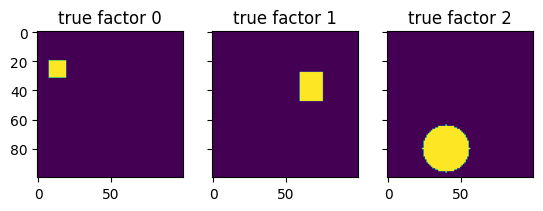

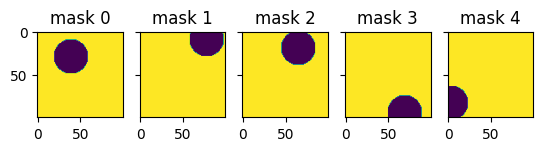

In [53]:
# Plot the factors
fig, axs = plt.subplots(1, num_factors, sharey=True)
for k in range(num_factors):
    axs[k].imshow(true_factors[k].reshape(height, width))
    axs[k].set_title("true factor {}".format(k))

# Plot the factors
fig, axs = plt.subplots(1, 5, sharey=True)
for m in range(5):
    axs[m].imshow(mask[m].reshape(height, width))
    axs[m].set_title("mask {}".format(m))

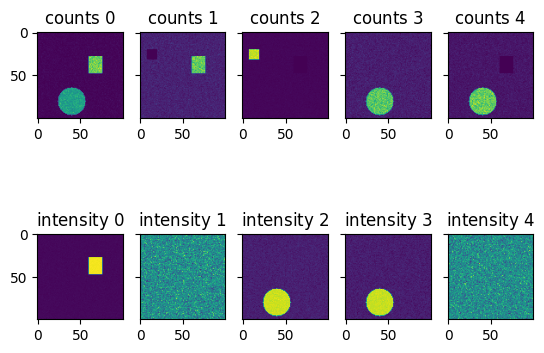

In [54]:
# Plot some of the data
fig, axs = plt.subplots(2, 5, sharey=True)
for m in jnp.arange(5):
    axs[0, m].imshow(counts[m].reshape(height, width))
    axs[0, m].set_title(r"counts ${}$".format(m))
    axs[1, m].imshow(intensity[m].reshape(height, width))
    axs[1, m].set_title(r"intensity ${}$".format(m))

## Fit the model!

In [5]:
mean_func = "softplus"
initial_params = None
sparsity_penalty = 0.0
# sparsity_penalty = 1 / loading_scale
elastic_net_frac = 1.0
num_iters = 10
num_coord_ascent_iters = 1

initial_params = seminmf.initialize_nnsvd(counts, intensity, num_factors, mean_func="softplus")

# Fit the model
params, losses, heldout_loglikes = \
    seminmf.fit_poisson_seminmf(counts,
                                intensity,
                                initial_params,
                                mask=mask,
                                mean_func=mean_func,
                                sparsity_penalty=sparsity_penalty,
                                elastic_net_frac=elastic_net_frac,
                                num_iters=num_iters,
                                num_coord_ascent_iters=num_coord_ascent_iters,
                                tolerance=1e-8
                                )

Text(0, 0.5, 'heldout log like')

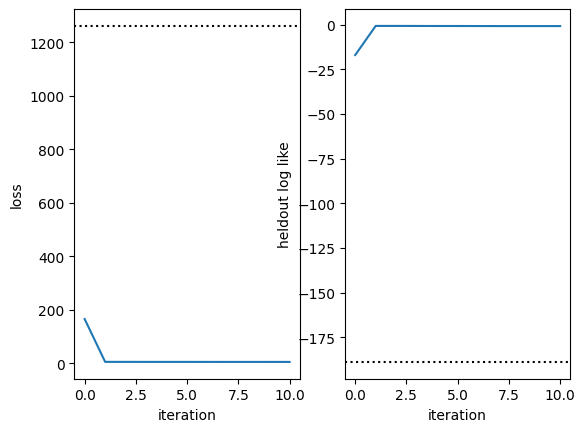

In [6]:
# Plot the losses
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses)

axs[0].axhline(seminmf.compute_loss(counts, intensity, mask, true_params, mean_func, sparsity_penalty, elastic_net_frac),
            ls=':', color='k', label='loss with true params')
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("loss")

axs[1].plot(heldout_loglikes)
axs[1].axhline(seminmf.heldout_loglike(counts, intensity, mask, true_params, mean_func),
            ls=':', color='k', label='loss with true params')
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("heldout log like")


In [7]:
from scipy.optimize import linear_sum_assignment
from dataclasses import replace

def permute_parameters(params, true_params):
    def find_permutation(factors, true_factors):
        """
        Find the permutation of the inferred factors so that they best align
        with the true factors

        Returns:
            permutation such that ``jnp.take(perm, factors)`` best aligns with ``true_factors``.
            
        """
        overlap = jnp.einsum('k...,j...->kj', true_factors, factors) 
        _, perm = linear_sum_assignment(-overlap)
        unused = set(range(len(factors))) - set(perm)
        if len(unused) > 0:
            return jnp.concatenate([perm, jnp.array(list(unused))])
        else:
            return perm

    perm = find_permutation(params.factors, true_params.factors)
    perm_factors = jnp.take(params.factors, perm, axis=0)
    perm_count_loadings = jnp.take(params.count_loadings, perm, axis=1)
    perm_intensity_loadings = jnp.take(params.intensity_loadings, perm, axis=1)
    return replace(params, 
                   factors=perm_factors, 
                   count_loadings=perm_count_loadings,
                   intensity_loadings=perm_intensity_loadings,
                   )

params = permute_parameters(params, true_params)

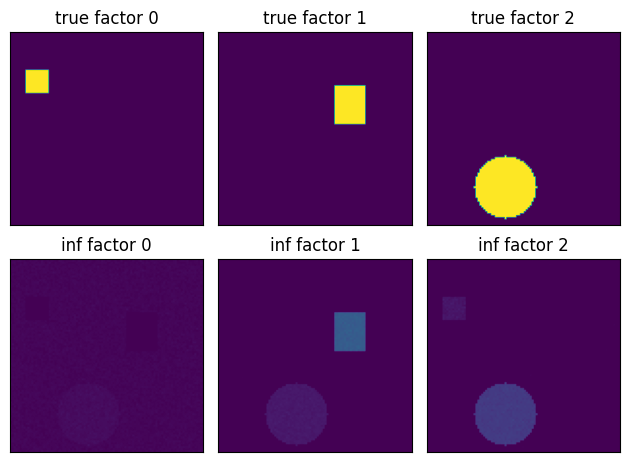

In [38]:
# Plot the factors
fig, axs = plt.subplots(2, params.num_factors)
for k in range(params.num_factors):
    if len(true_factors) > k:
        axs[0, k].imshow(true_factors[k].reshape(height, width))
        axs[0, k].set_title("true factor {}".format(k))
    else:
        axs[0, k].set_visible(False)
    
    axs[1, k].imshow(params.factors[k].reshape(height, width), vmin=0, vmax=true_factors.max())
    axs[1, k].set_title("inf factor {}".format(k))

    axs[0, k].set_xticks([])
    axs[0, k].set_yticks([])
    axs[1, k].set_xticks([])
    axs[1, k].set_yticks([])

plt.tight_layout()

In [9]:
print("true: ", true_params.count_loadings.mean(axis=0))
print("est:  ", params.count_loadings.mean(axis=0))

true:  [ 192.44943 -651.71344  634.8354 ]
est:   [  161.75673 -1917.8861    961.0625 ]


Text(0, 0.5, 'estimated row effect')

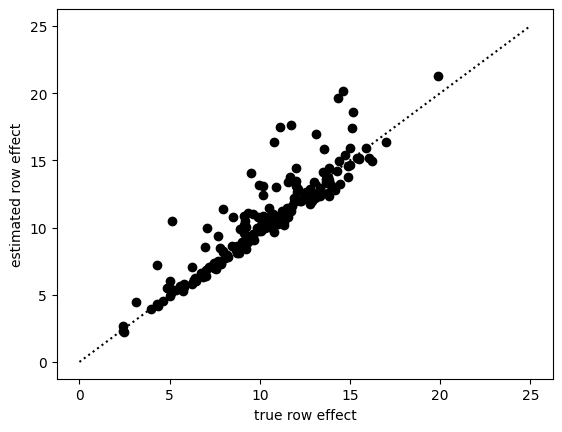

In [10]:
# plt.plot(jnp.arange(num_mice), true_params.count_row_effects, ls='none', marker='.', color='r')
# plt.plot(jnp.arange(num_mice), params.count_row_effects, ls='none', marker='o', color='k')
plt.plot(true_params.count_row_effects, params.count_row_effects, 'ko')
plt.plot([0, 25], [0, 25], ':k')
plt.xlabel("true row effect")
plt.ylabel("estimated row effect")

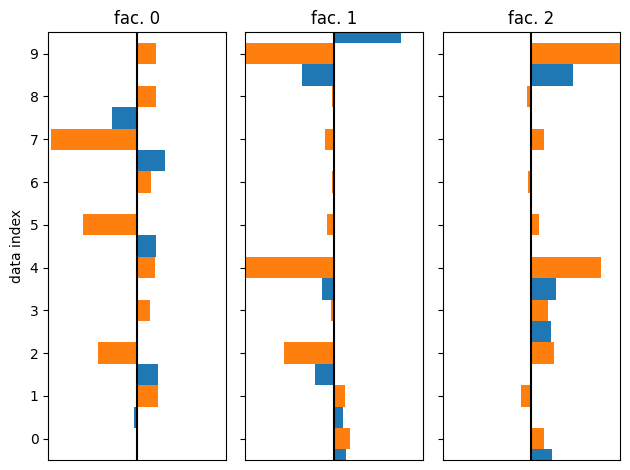

In [11]:
# Plot the loadings
fig, axs = plt.subplots(1, params.num_factors, sharey=True)

xmax = 3 * loading_scale
for k in range(params.num_factors):
    if num_factors > k:
        axs[k].barh(jnp.arange(num_mice), true_count_loadings[:, k], height=0.5, label='true')
    else:
        axs[k].barh(jnp.arange(num_mice), jnp.zeros(num_mice), height=0.5, label='true')
    axs[k].barh(jnp.arange(num_mice)+.5, params.count_loadings[:, k], height=0.5, label='inf')
    axs[k].axvline(0, color='k')
    axs[k].set_title("fac. {}".format(k))
    axs[k].set_yticks(jnp.arange(num_mice) + .5)
    axs[k].set_yticklabels(jnp.arange(num_mice))
    # axs[k].set_xlabel("loading")
    axs[k].set_xlim(-xmax, xmax)
    axs[k].set_xticks([])

    
    if k == 0:
        axs[k].set_ylabel("data index")
        
    axs[k].set_ylim(0, 10)
    
    # if k == num_factors - 1:
    #     axs[k].legend(loc="lower right")

    plt.tight_layout()

<BarContainer object of 3 artists>

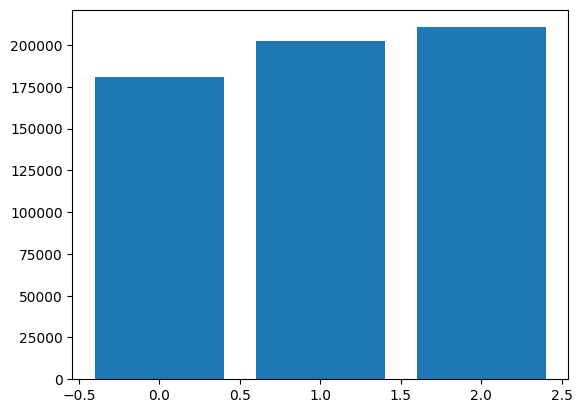

In [12]:
plt.bar(jnp.arange(params.num_factors), jnp.sqrt(jnp.sum(params.count_loadings ** 2, axis=0)))

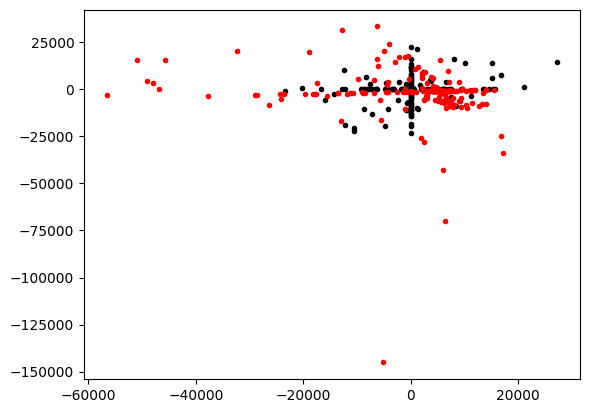

In [14]:
plt.plot(true_params.count_loadings[:, 0],
         true_params.count_loadings[:, 1],
         'k.')
plt.plot(params.count_loadings[:, 0],
         params.count_loadings[:, 1],
         'r.')

In [62]:
# Try ica
import numpy as np
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
ica_loadings = ica.fit_transform(np.array(intensity - true_intensity_row_effects[:, None], dtype=np.float32))

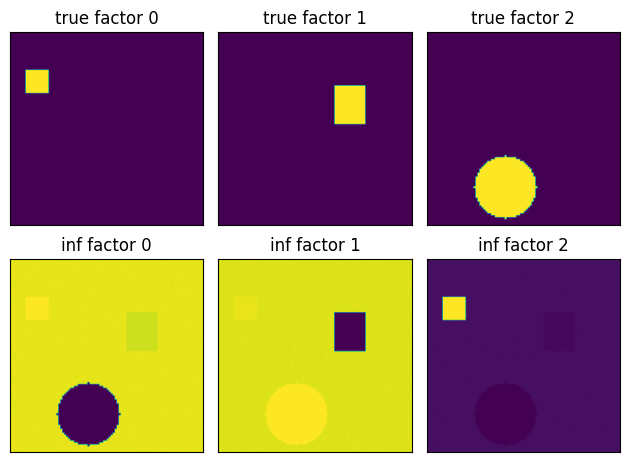

In [63]:
# Plot the factors
fig, axs = plt.subplots(2, params.num_factors)
for k in range(params.num_factors):
    if len(true_factors) > k:
        axs[0, k].imshow(true_factors[k].reshape(height, width))
        axs[0, k].set_title("true factor {}".format(k))
    else:
        axs[0, k].set_visible(False)
    
    axs[1, k].imshow(ica.components_[k].reshape(height, width))
    axs[1, k].set_title("inf factor {}".format(k))

    axs[0, k].set_xticks([])
    axs[0, k].set_yticks([])
    axs[1, k].set_xticks([])
    axs[1, k].set_yticks([])

plt.tight_layout()

In [67]:
np.linalg.norm(ica.components_, axis=1)

array([4.5122670e-05, 2.5348707e-05, 1.7809531e-05], dtype=float32)

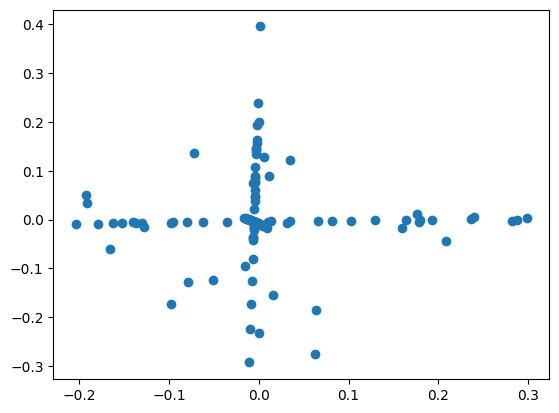

In [72]:
plt.scatter(ica_loadings[:, 1], ica_loadings[:, 2])